In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten,Dropout
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint,CSVLogger

Using TensorFlow backend.


In [2]:
token = 'C:/Users/pragya saraswat/Desktop/major/major2/text/Flickr8k.token.txt'

In [3]:
captions = open(token, 'r').read().strip().split('\n')

In [4]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [5]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
images = 'C:/Users/pragya saraswat/Desktop/major/major2/images/Flicker8k_Dataset/'

In [7]:
img = glob.glob(images+'*.jpg')

In [8]:
img[:5]

['C:/Users/pragya saraswat/Desktop/major/major2/images/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'C:/Users/pragya saraswat/Desktop/major/major2/images/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'C:/Users/pragya saraswat/Desktop/major/major2/images/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'C:/Users/pragya saraswat/Desktop/major/major2/images/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'C:/Users/pragya saraswat/Desktop/major/major2/images/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [9]:
train_images_file = 'C:/Users/pragya saraswat/Desktop/major/major2/text/Flickr_8k.trainImages.txt'

In [10]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [11]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [12]:
train_img = split_data(train_images)
len(train_img)

6000

In [15]:
val_images_file = 'C:/Users/pragya saraswat/Desktop/major/major2/text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [16]:
val_img = split_data(val_images)
len(val_img)

1000

In [18]:
test_images_file = 'C:/Users/pragya saraswat/Desktop/major/major2/text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [22]:
test_img = split_data(test_images)
len(test_img)

1000

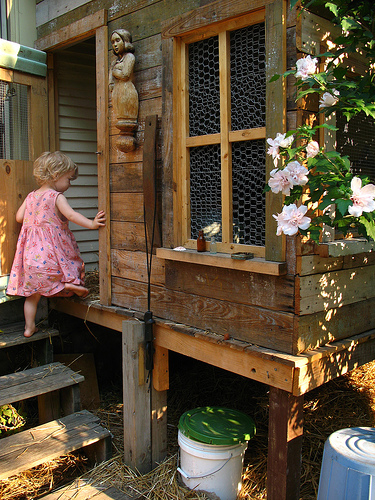

In [23]:
Image.open(train_img[0])

In [24]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [25]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


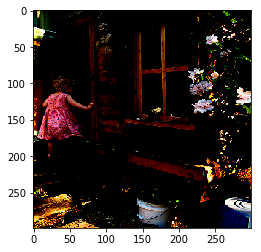

In [26]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [27]:
model = InceptionV3(weights='imagenet')

In [28]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [29]:
tryi = model_new.predict(preprocess(train_img[0]))

In [37]:
tryi.shape

(1, 2048)

In [33]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [36]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  1%|▊                                                                             | 63/6000 [01:12<2:04:38,  1.26s/it]

KeyboardInterrupt: 

In [ ]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [38]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

EOFError: Ran out of input

In [39]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

KeyError: '3556792157_d09d42bef7.jpg'

In [ ]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

In [ ]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle: pickle.dump(encoding_test, encoded_pickle)

In [40]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'encoded_images_test_inceptionV3.p'

In [ ]:
encoding_test[test_img[0][len(images):]].shape

In [220]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [221]:
len(train_d)

6000

In [222]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [223]:
len(val_d)

1000

In [224]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [225]:
len(test_d)

1000

In [226]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [227]:
words = [i.split() for i in caps]

In [228]:
unique = []
for i in words:
    unique.extend(i)

In [229]:
unique = list(set(unique))

In [230]:
unique = pickle.load(open('C:/Users/pragya saraswat/Desktop/major/major2/unique.p', 'rb'))

In [231]:
len(unique)

8256

In [232]:
word2idx = {val:index for index, val in enumerate(unique)}

In [233]:
word2idx['<start>']

5553

In [234]:
idx2word = {index:val for index, val in enumerate(unique)}

In [235]:
idx2word[5553]

'<start>'

In [236]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [237]:
len(unique), max_len

(8256, 40)

In [238]:
vocab_size = len(unique)

In [239]:
vocab_size

8256

In [240]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [241]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [242]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [243]:
len(df)

30000

In [244]:
c = [i for i in df['captions']]
len(c)

30000

In [245]:
imgs = [i for i in df['image_id']]

In [246]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [247]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5553
Woman => 860
writing => 3643
on => 803
a => 32
pad => 6042
in => 8156
room => 7022
with => 4350
gold => 8122
, => 5672
decorated => 4539
walls => 7915
. => 7023
<end> => 5232


In [248]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [249]:
samples_per_epoch

383454

In [250]:
steps = len(train_img)

In [251]:
def data_generator(batch_size):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])

        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    
                    n = np.zeros(vocab_size)
                   
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [252]:
embedding_size = 300

In [253]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        Dropout(0.5),
        RepeatVector(max_len)
    ])
image_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_16 (Dense)                 (None, 300)           614700      dense_input_5[0][0]              
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 300)           0           dense_16[0][0]                   
____________________________________________________________________________________________________
repeatvector_5 (RepeatVector)    (None, 40, 300)       0           dropout_9[0][0]                  
Total params: 614,700
Trainable params: 614,700
Non-trainable params: 0
____________________________________________________________________________________________________


In [254]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len,mask_zero = True),
        Dropout(0.5),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])
caption_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_5 (Embedding)          (None, 40, 300)       2476800     embedding_input_5[0][0]          
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 40, 300)       0           embedding_5[0][0]                
____________________________________________________________________________________________________
lstm_12 (LSTM)                   (None, 40, 256)       570368      dropout_10[0][0]                 
____________________________________________________________________________________________________
timedistributed_5 (TimeDistribut (None, 40, 300)       77100       lstm_12[0][0]                    
Total params: 3,124,268
Trainable params: 3,124,268
Non-trainable params: 0
_______________

In [255]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])
final_model.load_weights('C:/Users/pragya saraswat/Desktop/major/major2/w1.h5')

In [256]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [257]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_16 (Dense)                 (None, 300)           614700                                       
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 300)           0                                            
____________________________________________________________________________________________________
repeatvector_5 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 40, 300)       2476800                                      
___________________________________________________________________________________________

In [259]:
final_model.load_weights('C:/Users/pragya saraswat/Desktop/major/major2/w1.h5')

In [205]:
checkpointer = ModelCheckpoint(filepath= "checkpoint.hdf5",save_best_only = True)
csvloggr = CSVLogger("history.log",'w')
history = final_model.fit_generator(data_generator(batch_size=512), samples_per_epoch=samples_per_epoch, nb_epoch=100)
model.save(final_model)

Epoch 1/10


 99328/383454 [======>.......................] - ETA: 220476s - loss: 9.0122 - acc: 0.0000e+ - ETA: 125352s - loss: 8.9166 - acc: 0.0244   - ETA: 89157s - loss: 8.6789 - acc: 0.0462 - ETA: 70985s - loss: 8.2896 - acc: 0.054 - ETA: 60207s - loss: 7.8611 - acc: 0.058 - ETA: 52658s - loss: 7.4891 - acc: 0.064 - ETA: 47872s - loss: 7.2216 - acc: 0.069 - ETA: 44059s - loss: 7.0317 - acc: 0.075 - ETA: 41071s - loss: 6.8726 - acc: 0.078 - ETA: 38546s - loss: 6.7116 - acc: 0.083 - ETA: 36611s - loss: 6.5989 - acc: 0.083 - ETA: 34930s - loss: 6.5179 - acc: 0.087 - ETA: 33363s - loss: 6.4363 - acc: 0.091 - ETA: 32018s - loss: 6.3548 - acc: 0.093 - ETA: 30918s - loss: 6.2913 - acc: 0.095 - ETA: 29984s - loss: 6.2282 - acc: 0.100 - ETA: 29136s - loss: 6.1724 - acc: 0.103 - ETA: 28369s - loss: 6.1317 - acc: 0.106 - ETA: 27672s - loss: 6.0956 - acc: 0.108 - ETA: 27060s - loss: 6.0629 - acc: 0.110 - ETA: 26504s - loss: 6.0221 - acc: 0.111 - ETA: 25993s - loss: 5.9913 - acc: 0.114 - ETA: 25528s - loss

304640/383454 [======================>.......] - ETA: 8580s - loss: 4.7891 - acc: 0.21 - ETA: 8555s - loss: 4.7881 - acc: 0.21 - ETA: 8531s - loss: 4.7868 - acc: 0.21 - ETA: 8507s - loss: 4.7856 - acc: 0.21 - ETA: 8482s - loss: 4.7844 - acc: 0.21 - ETA: 8459s - loss: 4.7838 - acc: 0.21 - ETA: 8434s - loss: 4.7821 - acc: 0.21 - ETA: 8410s - loss: 4.7812 - acc: 0.21 - ETA: 8387s - loss: 4.7796 - acc: 0.21 - ETA: 8363s - loss: 4.7785 - acc: 0.21 - ETA: 8339s - loss: 4.7773 - acc: 0.21 - ETA: 8314s - loss: 4.7767 - acc: 0.21 - ETA: 8289s - loss: 4.7758 - acc: 0.21 - ETA: 8264s - loss: 4.7751 - acc: 0.21 - ETA: 8240s - loss: 4.7748 - acc: 0.21 - ETA: 8216s - loss: 4.7736 - acc: 0.21 - ETA: 8192s - loss: 4.7727 - acc: 0.21 - ETA: 8167s - loss: 4.7716 - acc: 0.21 - ETA: 8142s - loss: 4.7709 - acc: 0.21 - ETA: 8118s - loss: 4.7705 - acc: 0.21 - ETA: 8094s - loss: 4.7697 - acc: 0.21 - ETA: 8069s - loss: 4.7688 - acc: 0.21 - ETA: 8045s - loss: 4.7678 - acc: 0.21 - ETA: 8021s - loss: 4.7670 - acc

382976/383454 [============================>.] - ETA: 3660s - loss: 4.6121 - acc: 0.24 - ETA: 3636s - loss: 4.6110 - acc: 0.24 - ETA: 3612s - loss: 4.6102 - acc: 0.24 - ETA: 3588s - loss: 4.6096 - acc: 0.24 - ETA: 3564s - loss: 4.6090 - acc: 0.24 - ETA: 3541s - loss: 4.6084 - acc: 0.24 - ETA: 3517s - loss: 4.6078 - acc: 0.24 - ETA: 3492s - loss: 4.6072 - acc: 0.24 - ETA: 3468s - loss: 4.6063 - acc: 0.24 - ETA: 3444s - loss: 4.6061 - acc: 0.24 - ETA: 3420s - loss: 4.6056 - acc: 0.24 - ETA: 3396s - loss: 4.6048 - acc: 0.24 - ETA: 3372s - loss: 4.6038 - acc: 0.24 - ETA: 3349s - loss: 4.6033 - acc: 0.24 - ETA: 3325s - loss: 4.6025 - acc: 0.24 - ETA: 3301s - loss: 4.6016 - acc: 0.24 - ETA: 3276s - loss: 4.6006 - acc: 0.24 - ETA: 3252s - loss: 4.5998 - acc: 0.24 - ETA: 3229s - loss: 4.6000 - acc: 0.24 - ETA: 3205s - loss: 4.5992 - acc: 0.24 - ETA: 3181s - loss: 4.5988 - acc: 0.24 - ETA: 3157s - loss: 4.5977 - acc: 0.24 - ETA: 3133s - loss: 4.5970 - acc: 0.24 - ETA: 3109s - loss: 4.5965 - acc

C:\Users\15803034\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


383488/383454 [==============================] - 17920s - loss: 4.5143 - acc: 0.2544  
Epoch 2/10


 98304/383454 [======>.......................] - ETA: 17606s - loss: 4.0687 - acc: 0.294 - ETA: 17447s - loss: 4.1352 - acc: 0.293 - ETA: 17432s - loss: 4.1769 - acc: 0.295 - ETA: 17658s - loss: 4.2043 - acc: 0.292 - ETA: 17743s - loss: 4.1695 - acc: 0.294 - ETA: 17728s - loss: 4.1517 - acc: 0.301 - ETA: 17750s - loss: 4.1439 - acc: 0.303 - ETA: 17694s - loss: 4.1136 - acc: 0.305 - ETA: 17705s - loss: 4.1167 - acc: 0.304 - ETA: 17667s - loss: 4.0779 - acc: 0.308 - ETA: 17631s - loss: 4.0761 - acc: 0.307 - ETA: 17591s - loss: 4.0959 - acc: 0.306 - ETA: 17547s - loss: 4.0999 - acc: 0.304 - ETA: 17523s - loss: 4.0732 - acc: 0.306 - ETA: 17472s - loss: 4.0705 - acc: 0.305 - ETA: 17398s - loss: 4.0502 - acc: 0.309 - ETA: 17391s - loss: 4.0435 - acc: 0.310 - ETA: 17380s - loss: 4.0542 - acc: 0.309 - ETA: 17365s - loss: 4.0600 - acc: 0.307 - ETA: 17327s - loss: 4.0728 - acc: 0.307 - ETA: 17298s - loss: 4.0687 - acc: 0.306 - ETA: 17258s - loss: 4.0701 - acc: 0.307 - ETA: 17248s - loss: 4.0788 

303616/383454 [======================>.......] - ETA: 8543s - loss: 4.0427 - acc: 0.32 - ETA: 8518s - loss: 4.0418 - acc: 0.32 - ETA: 8494s - loss: 4.0420 - acc: 0.32 - ETA: 8470s - loss: 4.0415 - acc: 0.32 - ETA: 8447s - loss: 4.0411 - acc: 0.32 - ETA: 8422s - loss: 4.0409 - acc: 0.32 - ETA: 8399s - loss: 4.0407 - acc: 0.32 - ETA: 8375s - loss: 4.0410 - acc: 0.32 - ETA: 8352s - loss: 4.0407 - acc: 0.32 - ETA: 8328s - loss: 4.0407 - acc: 0.32 - ETA: 8304s - loss: 4.0398 - acc: 0.32 - ETA: 8280s - loss: 4.0399 - acc: 0.32 - ETA: 8257s - loss: 4.0397 - acc: 0.32 - ETA: 8234s - loss: 4.0401 - acc: 0.32 - ETA: 8209s - loss: 4.0401 - acc: 0.32 - ETA: 8185s - loss: 4.0408 - acc: 0.32 - ETA: 8162s - loss: 4.0410 - acc: 0.32 - ETA: 8138s - loss: 4.0410 - acc: 0.32 - ETA: 8115s - loss: 4.0409 - acc: 0.32 - ETA: 8092s - loss: 4.0407 - acc: 0.32 - ETA: 8067s - loss: 4.0410 - acc: 0.32 - ETA: 8045s - loss: 4.0416 - acc: 0.32 - ETA: 8021s - loss: 4.0417 - acc: 0.32 - ETA: 7997s - loss: 4.0419 - acc

383488/383454 [==============================] - ETA: 3689s - loss: 4.0337 - acc: 0.32 - ETA: 3666s - loss: 4.0337 - acc: 0.32 - ETA: 3642s - loss: 4.0333 - acc: 0.32 - ETA: 3618s - loss: 4.0328 - acc: 0.32 - ETA: 3594s - loss: 4.0327 - acc: 0.32 - ETA: 3570s - loss: 4.0327 - acc: 0.32 - ETA: 3547s - loss: 4.0328 - acc: 0.32 - ETA: 3523s - loss: 4.0332 - acc: 0.32 - ETA: 3499s - loss: 4.0334 - acc: 0.32 - ETA: 3475s - loss: 4.0333 - acc: 0.32 - ETA: 3452s - loss: 4.0333 - acc: 0.32 - ETA: 3428s - loss: 4.0337 - acc: 0.32 - ETA: 3404s - loss: 4.0337 - acc: 0.32 - ETA: 3380s - loss: 4.0336 - acc: 0.32 - ETA: 3356s - loss: 4.0330 - acc: 0.32 - ETA: 3332s - loss: 4.0333 - acc: 0.32 - ETA: 3309s - loss: 4.0331 - acc: 0.32 - ETA: 3285s - loss: 4.0329 - acc: 0.32 - ETA: 3261s - loss: 4.0326 - acc: 0.32 - ETA: 3237s - loss: 4.0324 - acc: 0.32 - ETA: 3213s - loss: 4.0333 - acc: 0.32 - ETA: 3190s - loss: 4.0334 - acc: 0.32 - ETA: 3166s - loss: 4.0335 - acc: 0.32 - ETA: 3142s - loss: 4.0332 - acc

101888/383454 [======>.......................] - ETA: 18061s - loss: 4.0139 - acc: 0.332 - ETA: 17852s - loss: 4.1067 - acc: 0.322 - ETA: 17935s - loss: 4.0790 - acc: 0.324 - ETA: 17872s - loss: 4.1264 - acc: 0.319 - ETA: 17854s - loss: 4.0915 - acc: 0.319 - ETA: 17894s - loss: 4.0642 - acc: 0.326 - ETA: 17892s - loss: 4.0541 - acc: 0.325 - ETA: 17852s - loss: 4.0229 - acc: 0.327 - ETA: 17801s - loss: 4.0242 - acc: 0.326 - ETA: 17812s - loss: 3.9755 - acc: 0.329 - ETA: 17782s - loss: 3.9839 - acc: 0.329 - ETA: 17719s - loss: 4.0095 - acc: 0.326 - ETA: 17680s - loss: 4.0124 - acc: 0.325 - ETA: 17648s - loss: 3.9840 - acc: 0.326 - ETA: 17633s - loss: 3.9859 - acc: 0.325 - ETA: 17607s - loss: 3.9646 - acc: 0.329 - ETA: 17567s - loss: 3.9587 - acc: 0.329 - ETA: 17574s - loss: 3.9773 - acc: 0.329 - ETA: 17549s - loss: 3.9874 - acc: 0.327 - ETA: 17532s - loss: 3.9957 - acc: 0.328 - ETA: 17517s - loss: 3.9964 - acc: 0.328 - ETA: 17487s - loss: 3.9879 - acc: 0.329 - ETA: 17434s - loss: 3.9983 

310784/383454 [=======================>......] - ETA: 4630s - loss: 3.9772 - acc: 0.33 - ETA: 4616s - loss: 3.9780 - acc: 0.33 - ETA: 4602s - loss: 3.9780 - acc: 0.33 - ETA: 4588s - loss: 3.9781 - acc: 0.33 - ETA: 4574s - loss: 3.9781 - acc: 0.33 - ETA: 4560s - loss: 3.9779 - acc: 0.33 - ETA: 4546s - loss: 3.9785 - acc: 0.33 - ETA: 4532s - loss: 3.9791 - acc: 0.33 - ETA: 4518s - loss: 3.9790 - acc: 0.33 - ETA: 4504s - loss: 3.9796 - acc: 0.33 - ETA: 4490s - loss: 3.9796 - acc: 0.33 - ETA: 4476s - loss: 3.9790 - acc: 0.33 - ETA: 4462s - loss: 3.9789 - acc: 0.33 - ETA: 4448s - loss: 3.9790 - acc: 0.33 - ETA: 4434s - loss: 3.9789 - acc: 0.33 - ETA: 4420s - loss: 3.9787 - acc: 0.33 - ETA: 4406s - loss: 3.9786 - acc: 0.33 - ETA: 4392s - loss: 3.9780 - acc: 0.33 - ETA: 4378s - loss: 3.9788 - acc: 0.33 - ETA: 4364s - loss: 3.9792 - acc: 0.33 - ETA: 4350s - loss: 3.9791 - acc: 0.33 - ETA: 4336s - loss: 3.9795 - acc: 0.33 - ETA: 4322s - loss: 3.9788 - acc: 0.33 - ETA: 4309s - loss: 3.9783 - acc

383488/383454 [==============================] - ETA: 1857s - loss: 3.9796 - acc: 0.33 - ETA: 1844s - loss: 3.9799 - acc: 0.33 - ETA: 1831s - loss: 3.9797 - acc: 0.33 - ETA: 1817s - loss: 3.9796 - acc: 0.33 - ETA: 1804s - loss: 3.9791 - acc: 0.33 - ETA: 1791s - loss: 3.9794 - acc: 0.33 - ETA: 1778s - loss: 3.9801 - acc: 0.33 - ETA: 1764s - loss: 3.9801 - acc: 0.33 - ETA: 1751s - loss: 3.9803 - acc: 0.33 - ETA: 1738s - loss: 3.9799 - acc: 0.33 - ETA: 1725s - loss: 3.9801 - acc: 0.33 - ETA: 1712s - loss: 3.9805 - acc: 0.33 - ETA: 1698s - loss: 3.9805 - acc: 0.33 - ETA: 1685s - loss: 3.9801 - acc: 0.33 - ETA: 1672s - loss: 3.9800 - acc: 0.33 - ETA: 1659s - loss: 3.9798 - acc: 0.33 - ETA: 1645s - loss: 3.9796 - acc: 0.33 - ETA: 1632s - loss: 3.9792 - acc: 0.33 - ETA: 1619s - loss: 3.9792 - acc: 0.33 - ETA: 1606s - loss: 3.9795 - acc: 0.33 - ETA: 1592s - loss: 3.9797 - acc: 0.33 - ETA: 1579s - loss: 3.9798 - acc: 0.33 - ETA: 1566s - loss: 3.9795 - acc: 0.33 - ETA: 1553s - loss: 3.9794 - acc

104448/383454 [=======>......................] - ETA: 9495s - loss: 3.8911 - acc: 0.34 - ETA: 9475s - loss: 4.1029 - acc: 0.32 - ETA: 9472s - loss: 4.0464 - acc: 0.32 - ETA: 9451s - loss: 4.1203 - acc: 0.32 - ETA: 9443s - loss: 4.0721 - acc: 0.32 - ETA: 9432s - loss: 4.0458 - acc: 0.32 - ETA: 9421s - loss: 4.0401 - acc: 0.32 - ETA: 9413s - loss: 3.9965 - acc: 0.33 - ETA: 9392s - loss: 4.0008 - acc: 0.32 - ETA: 9380s - loss: 3.9589 - acc: 0.33 - ETA: 9365s - loss: 3.9603 - acc: 0.33 - ETA: 9357s - loss: 3.9989 - acc: 0.33 - ETA: 9343s - loss: 3.9945 - acc: 0.32 - ETA: 9331s - loss: 3.9622 - acc: 0.33 - ETA: 9315s - loss: 3.9668 - acc: 0.33 - ETA: 9304s - loss: 3.9447 - acc: 0.33 - ETA: 9292s - loss: 3.9428 - acc: 0.33 - ETA: 9284s - loss: 3.9648 - acc: 0.33 - ETA: 9270s - loss: 3.9721 - acc: 0.33 - ETA: 9256s - loss: 3.9809 - acc: 0.33 - ETA: 9239s - loss: 3.9823 - acc: 0.33 - ETA: 9228s - loss: 3.9688 - acc: 0.33 - ETA: 9214s - loss: 3.9755 - acc: 0.33 - ETA: 9200s - loss: 3.9680 - acc

313344/383454 [=======================>......] - ETA: 4314s - loss: 3.9561 - acc: 0.33 - ETA: 4301s - loss: 3.9568 - acc: 0.33 - ETA: 4288s - loss: 3.9572 - acc: 0.33 - ETA: 4276s - loss: 3.9571 - acc: 0.33 - ETA: 4263s - loss: 3.9578 - acc: 0.33 - ETA: 4250s - loss: 3.9577 - acc: 0.33 - ETA: 4238s - loss: 3.9570 - acc: 0.33 - ETA: 4225s - loss: 3.9572 - acc: 0.33 - ETA: 4212s - loss: 3.9573 - acc: 0.33 - ETA: 4200s - loss: 3.9570 - acc: 0.33 - ETA: 4187s - loss: 3.9568 - acc: 0.33 - ETA: 4174s - loss: 3.9564 - acc: 0.33 - ETA: 4161s - loss: 3.9561 - acc: 0.33 - ETA: 4149s - loss: 3.9567 - acc: 0.33 - ETA: 4136s - loss: 3.9572 - acc: 0.33 - ETA: 4123s - loss: 3.9569 - acc: 0.33 - ETA: 4111s - loss: 3.9574 - acc: 0.33 - ETA: 4098s - loss: 3.9567 - acc: 0.33 - ETA: 4085s - loss: 3.9562 - acc: 0.33 - ETA: 4073s - loss: 3.9557 - acc: 0.33 - ETA: 4060s - loss: 3.9552 - acc: 0.33 - ETA: 4047s - loss: 3.9557 - acc: 0.33 - ETA: 4034s - loss: 3.9557 - acc: 0.33 - ETA: 4022s - loss: 3.9563 - acc

383488/383454 [==============================] - ETA: 1724s - loss: 3.9603 - acc: 0.33 - ETA: 1712s - loss: 3.9608 - acc: 0.33 - ETA: 1699s - loss: 3.9606 - acc: 0.33 - ETA: 1686s - loss: 3.9609 - acc: 0.33 - ETA: 1674s - loss: 3.9606 - acc: 0.33 - ETA: 1661s - loss: 3.9609 - acc: 0.33 - ETA: 1648s - loss: 3.9611 - acc: 0.33 - ETA: 1636s - loss: 3.9611 - acc: 0.33 - ETA: 1623s - loss: 3.9608 - acc: 0.33 - ETA: 1610s - loss: 3.9606 - acc: 0.33 - ETA: 1598s - loss: 3.9604 - acc: 0.33 - ETA: 1585s - loss: 3.9602 - acc: 0.33 - ETA: 1572s - loss: 3.9599 - acc: 0.33 - ETA: 1560s - loss: 3.9600 - acc: 0.33 - ETA: 1547s - loss: 3.9603 - acc: 0.33 - ETA: 1534s - loss: 3.9606 - acc: 0.33 - ETA: 1521s - loss: 3.9605 - acc: 0.33 - ETA: 1509s - loss: 3.9602 - acc: 0.33 - ETA: 1496s - loss: 3.9603 - acc: 0.33 - ETA: 1483s - loss: 3.9599 - acc: 0.33 - ETA: 1471s - loss: 3.9601 - acc: 0.33 - ETA: 1458s - loss: 3.9600 - acc: 0.33 - ETA: 1445s - loss: 3.9604 - acc: 0.33 - ETA: 1433s - loss: 3.9605 - acc

104448/383454 [=======>......................] - ETA: 9645s - loss: 3.9511 - acc: 0.34 - ETA: 9550s - loss: 4.1164 - acc: 0.32 - ETA: 9516s - loss: 4.0855 - acc: 0.33 - ETA: 9503s - loss: 4.1026 - acc: 0.32 - ETA: 9474s - loss: 4.0732 - acc: 0.32 - ETA: 9494s - loss: 4.0278 - acc: 0.33 - ETA: 9469s - loss: 4.0400 - acc: 0.32 - ETA: 9451s - loss: 3.9821 - acc: 0.33 - ETA: 9425s - loss: 3.9866 - acc: 0.32 - ETA: 9403s - loss: 3.9525 - acc: 0.33 - ETA: 9378s - loss: 3.9504 - acc: 0.33 - ETA: 9358s - loss: 3.9873 - acc: 0.32 - ETA: 9341s - loss: 3.9751 - acc: 0.33 - ETA: 9326s - loss: 3.9492 - acc: 0.32 - ETA: 9307s - loss: 3.9558 - acc: 0.33 - ETA: 9293s - loss: 3.9341 - acc: 0.33 - ETA: 9290s - loss: 3.9295 - acc: 0.33 - ETA: 9279s - loss: 3.9609 - acc: 0.33 - ETA: 9261s - loss: 3.9615 - acc: 0.33 - ETA: 9249s - loss: 3.9687 - acc: 0.33 - ETA: 9232s - loss: 3.9735 - acc: 0.33 - ETA: 9228s - loss: 3.9619 - acc: 0.33 - ETA: 9216s - loss: 3.9646 - acc: 0.33 - ETA: 9202s - loss: 3.9561 - acc

313344/383454 [=======================>......] - ETA: 4316s - loss: 3.9485 - acc: 0.33 - ETA: 4303s - loss: 3.9492 - acc: 0.33 - ETA: 4290s - loss: 3.9494 - acc: 0.33 - ETA: 4277s - loss: 3.9495 - acc: 0.33 - ETA: 4265s - loss: 3.9500 - acc: 0.33 - ETA: 4252s - loss: 3.9502 - acc: 0.33 - ETA: 4239s - loss: 3.9495 - acc: 0.33 - ETA: 4227s - loss: 3.9496 - acc: 0.33 - ETA: 4214s - loss: 3.9498 - acc: 0.33 - ETA: 4201s - loss: 3.9496 - acc: 0.33 - ETA: 4189s - loss: 3.9495 - acc: 0.33 - ETA: 4176s - loss: 3.9491 - acc: 0.33 - ETA: 4163s - loss: 3.9489 - acc: 0.33 - ETA: 4150s - loss: 3.9497 - acc: 0.33 - ETA: 4138s - loss: 3.9501 - acc: 0.33 - ETA: 4125s - loss: 3.9501 - acc: 0.33 - ETA: 4112s - loss: 3.9504 - acc: 0.33 - ETA: 4099s - loss: 3.9496 - acc: 0.33 - ETA: 4087s - loss: 3.9492 - acc: 0.33 - ETA: 4074s - loss: 3.9487 - acc: 0.33 - ETA: 4061s - loss: 3.9483 - acc: 0.33 - ETA: 4049s - loss: 3.9485 - acc: 0.33 - ETA: 4036s - loss: 3.9486 - acc: 0.33 - ETA: 4023s - loss: 3.9492 - acc

383488/383454 [==============================] - ETA: 1725s - loss: 3.9510 - acc: 0.33 - ETA: 1712s - loss: 3.9516 - acc: 0.33 - ETA: 1699s - loss: 3.9515 - acc: 0.33 - ETA: 1687s - loss: 3.9516 - acc: 0.33 - ETA: 1674s - loss: 3.9514 - acc: 0.33 - ETA: 1661s - loss: 3.9518 - acc: 0.33 - ETA: 1649s - loss: 3.9520 - acc: 0.33 - ETA: 1636s - loss: 3.9519 - acc: 0.33 - ETA: 1623s - loss: 3.9515 - acc: 0.33 - ETA: 1611s - loss: 3.9513 - acc: 0.33 - ETA: 1598s - loss: 3.9510 - acc: 0.33 - ETA: 1585s - loss: 3.9509 - acc: 0.33 - ETA: 1573s - loss: 3.9506 - acc: 0.33 - ETA: 1560s - loss: 3.9505 - acc: 0.33 - ETA: 1547s - loss: 3.9508 - acc: 0.33 - ETA: 1535s - loss: 3.9509 - acc: 0.33 - ETA: 1522s - loss: 3.9508 - acc: 0.33 - ETA: 1509s - loss: 3.9505 - acc: 0.33 - ETA: 1497s - loss: 3.9507 - acc: 0.33 - ETA: 1484s - loss: 3.9501 - acc: 0.33 - ETA: 1471s - loss: 3.9502 - acc: 0.33 - ETA: 1458s - loss: 3.9503 - acc: 0.33 - ETA: 1446s - loss: 3.9505 - acc: 0.33 - ETA: 1433s - loss: 3.9508 - acc

104448/383454 [=======>......................] - ETA: 9891s - loss: 3.7918 - acc: 0.36 - ETA: 10047s - loss: 4.0688 - acc: 0.335 - ETA: 10043s - loss: 4.0422 - acc: 0.335 - ETA: 10037s - loss: 4.0709 - acc: 0.324 - ETA: 9969s - loss: 4.0611 - acc: 0.323 - ETA: 9928s - loss: 4.0266 - acc: 0.33 - ETA: 9912s - loss: 4.0159 - acc: 0.33 - ETA: 9854s - loss: 3.9674 - acc: 0.33 - ETA: 9826s - loss: 3.9721 - acc: 0.32 - ETA: 9795s - loss: 3.9388 - acc: 0.33 - ETA: 9757s - loss: 3.9390 - acc: 0.33 - ETA: 9725s - loss: 3.9719 - acc: 0.33 - ETA: 9709s - loss: 3.9568 - acc: 0.33 - ETA: 9683s - loss: 3.9430 - acc: 0.33 - ETA: 9658s - loss: 3.9547 - acc: 0.33 - ETA: 9645s - loss: 3.9335 - acc: 0.33 - ETA: 9635s - loss: 3.9284 - acc: 0.33 - ETA: 9609s - loss: 3.9598 - acc: 0.33 - ETA: 9588s - loss: 3.9595 - acc: 0.33 - ETA: 9574s - loss: 3.9606 - acc: 0.33 - ETA: 9554s - loss: 3.9667 - acc: 0.33 - ETA: 9538s - loss: 3.9555 - acc: 0.33 - ETA: 9520s - loss: 3.9628 - acc: 0.33 - ETA: 9509s - loss: 3.950

313344/383454 [=======================>......] - ETA: 4460s - loss: 3.9407 - acc: 0.33 - ETA: 4447s - loss: 3.9414 - acc: 0.33 - ETA: 4433s - loss: 3.9416 - acc: 0.33 - ETA: 4420s - loss: 3.9416 - acc: 0.33 - ETA: 4407s - loss: 3.9421 - acc: 0.33 - ETA: 4394s - loss: 3.9422 - acc: 0.33 - ETA: 4380s - loss: 3.9417 - acc: 0.33 - ETA: 4367s - loss: 3.9420 - acc: 0.33 - ETA: 4354s - loss: 3.9422 - acc: 0.33 - ETA: 4341s - loss: 3.9419 - acc: 0.33 - ETA: 4328s - loss: 3.9417 - acc: 0.33 - ETA: 4315s - loss: 3.9414 - acc: 0.33 - ETA: 4301s - loss: 3.9413 - acc: 0.33 - ETA: 4288s - loss: 3.9420 - acc: 0.33 - ETA: 4275s - loss: 3.9423 - acc: 0.33 - ETA: 4262s - loss: 3.9422 - acc: 0.33 - ETA: 4249s - loss: 3.9429 - acc: 0.33 - ETA: 4235s - loss: 3.9423 - acc: 0.33 - ETA: 4222s - loss: 3.9416 - acc: 0.33 - ETA: 4209s - loss: 3.9410 - acc: 0.33 - ETA: 4196s - loss: 3.9408 - acc: 0.33 - ETA: 4183s - loss: 3.9409 - acc: 0.33 - ETA: 4169s - loss: 3.9410 - acc: 0.33 - ETA: 4156s - loss: 3.9418 - acc

355840/383454 [==========================>...] - ETA: 1771s - loss: 3.9431 - acc: 0.33 - ETA: 1758s - loss: 3.9435 - acc: 0.33 - ETA: 1745s - loss: 3.9435 - acc: 0.33 - ETA: 1732s - loss: 3.9438 - acc: 0.33 - ETA: 1718s - loss: 3.9433 - acc: 0.33 - ETA: 1705s - loss: 3.9437 - acc: 0.33 - ETA: 1692s - loss: 3.9438 - acc: 0.33 - ETA: 1679s - loss: 3.9437 - acc: 0.33 - ETA: 1666s - loss: 3.9435 - acc: 0.33 - ETA: 1653s - loss: 3.9434 - acc: 0.33 - ETA: 1640s - loss: 3.9433 - acc: 0.33 - ETA: 1627s - loss: 3.9430 - acc: 0.33 - ETA: 1614s - loss: 3.9428 - acc: 0.33 - ETA: 1601s - loss: 3.9429 - acc: 0.33 - ETA: 1587s - loss: 3.9432 - acc: 0.33 - ETA: 1574s - loss: 3.9433 - acc: 0.33 - ETA: 1561s - loss: 3.9432 - acc: 0.33 - ETA: 1548s - loss: 3.9428 - acc: 0.33 - ETA: 1535s - loss: 3.9432 - acc: 0.33 - ETA: 1522s - loss: 3.9425 - acc: 0.33 - ETA: 1509s - loss: 3.9428 - acc: 0.33 - ETA: 1496s - loss: 3.9431 - acc: 0.33 - ETA: 1483s - loss: 3.9433 - acc: 0.33 - ETA: 1470s - loss: 3.9434 - acc

KeyboardInterrupt: 

In [260]:
final_model.save_weights('C:/Users/pragya saraswat/Desktop/major/major2/w1.h5')

In [261]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [262]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
           
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

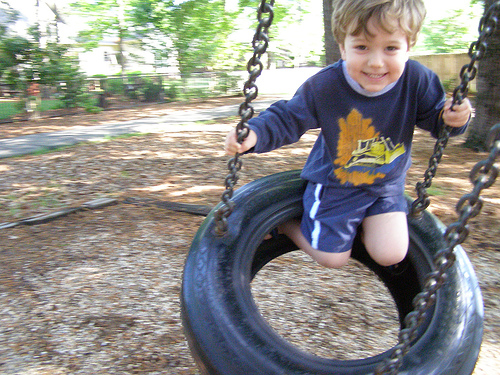

In [355]:
try_image = test_img[41]
Image.open(try_image)

In [356]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A little girl in a blue shirt is jumping over a swing .
Beam Search, k=3: A little girl in a pink shirt is sitting on a swing .
Beam Search, k=5: A little girl and a little girl playing in a field .
Beam Search, k=7: A little girl and a little girl play in a field .


In [340]:
t = try_image[-25:]
p = {}
p = d[t]
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
reference = p[0]
candidate = predict_captions(try_image)
cc = SmoothingFunction()
score = sentence_bleu(reference, candidate, smoothing_function=cc.method4)
print(score)
print(p[0])
print(candidate)
if score > 0.7:
    print("good prediction")
elif score < 0.3:
    print("bad prediction")
else:
    print("nither good nor bad prediction")

0.31926413019165306
Four girls in evening attire pose for a picture .
A group of young women pose for a picture .
nither good nor bad prediction


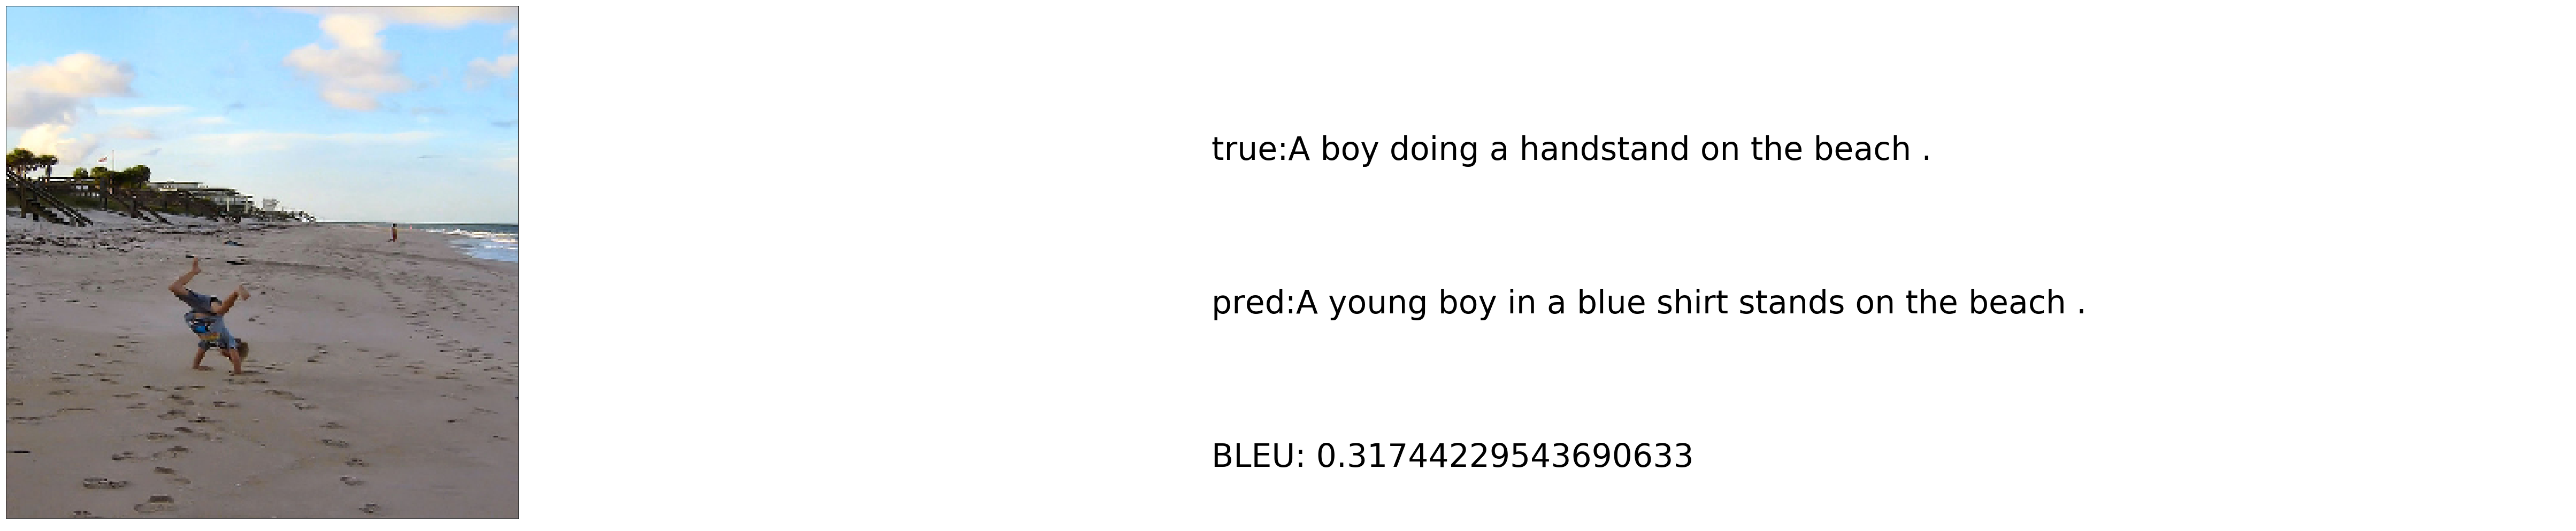

In [280]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
npix = 299
target_size = (npix,npix,3)
fig = plt.figure(figsize=(100,800))
npic = len(reference)
filename = try_image
image_load = load_img(filename, target_size=target_size)
ax = fig.add_subplot(npic,2,1,xticks=[],yticks=[])
ax.imshow(image_load)
ax = fig.add_subplot(npic,2,2)
plt.axis('off')
ax.plot()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.text(0,0.7,"true:" + reference,fontsize=60)
ax.text(0,0.4,"pred:" + candidate,fontsize=60)
ax.text(0,0.1,"BLEU: {}".format(score),fontsize=60)
plt.show()

In [281]:
import pickle
file_name = "C:/Users/15803034/Desktop/major2/text2emoji-master/data/psychexp.txt" 

def read_file(file_name): 
    data_list  = []
    with open(file_name, 'r') as f: 
        for line in f: 
            line = line.strip() 
            label = ' '.join(line[1:line.find("]")].strip().split())
            text = line[line.find("]")+1:].strip()
            data_list.append([label, text])
    return data_list


In [282]:
psychExp_txt = read_file(file_name)

In [283]:
print("The number of instances: {}".format(len(psychExp_txt)))

The number of instances: 7480


In [284]:
print("Data example: ")
print(psychExp_txt[0])

Data example: 
['1. 0. 0. 0. 0. 0. 0.', 'During the period of falling in love, each time that we met and especially when we had not met for a long time.']


In [285]:
import re 
from collections import Counter

In [286]:
def ngram(token, n): 
    output = []
    for i in range(n-1, len(token)): 
        ngram = ' '.join(token[i-n+1:i+1])
        output.append(ngram) 
    return output

In [287]:
def create_feature(text, nrange=(1, 1)):
    text_features = [] 
    text = text.lower() 

    # 1. treat alphanumeric characters as word tokens
    # Since tweets contain #, we keep it as a feature
    # Then, extract all ngram lengths
    text_alphanum = re.sub('[^a-z0-9#]', ' ', text)
    for n in range(nrange[0], nrange[1]+1): 
        text_features += ngram(text_alphanum.split(), n)
    
    # 2. treat punctuations as word token
    text_punc = re.sub('[a-z0-9]', ' ', text)
    text_features += ngram(text_punc.split(), 1)
    
    # 3. Return a dictinaory whose keys are the list of elements 
    # and their values are the number of times appearede in the list.
    return Counter(text_features)

In [288]:
print(create_feature("I love you!"))
print(create_feature(" aly wins the gold!!!!!!  #olympics"))
print(create_feature(" aly wins the gold!!!!!!  #olympics", (1, 2)))

Counter({'i': 1, 'love': 1, 'you': 1, '!': 1})
Counter({'aly': 1, 'wins': 1, 'the': 1, 'gold': 1, '#olympics': 1, '!!!!!!': 1, '#': 1})
Counter({'aly': 1, 'wins': 1, 'the': 1, 'gold': 1, '#olympics': 1, 'aly wins': 1, 'wins the': 1, 'the gold': 1, 'gold #olympics': 1, '!!!!!!': 1, '#': 1})


In [289]:
def convert_label(item, name): 
    items = list(map(float, item.split()))
    label = ""
    for idx in range(len(items)): 
        if items[idx] == 1: 
            label += name[idx] + " "
    
    return label.strip()

In [290]:
emotions = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]

X_all = []
y_all = []
for label, text in psychExp_txt:
    y_all.append(convert_label(label, emotions))
    X_all.append(create_feature(text, nrange=(1, 4)))

In [291]:
print("features example: ")
print(X_all[0])

features example: 
Counter({'time': 2, 'we': 2, 'met': 2, 'during': 1, 'the': 1, 'period': 1, 'of': 1, 'falling': 1, 'in': 1, 'love': 1, 'each': 1, 'that': 1, 'and': 1, 'especially': 1, 'when': 1, 'had': 1, 'not': 1, 'for': 1, 'a': 1, 'long': 1, 'during the': 1, 'the period': 1, 'period of': 1, 'of falling': 1, 'falling in': 1, 'in love': 1, 'love each': 1, 'each time': 1, 'time that': 1, 'that we': 1, 'we met': 1, 'met and': 1, 'and especially': 1, 'especially when': 1, 'when we': 1, 'we had': 1, 'had not': 1, 'not met': 1, 'met for': 1, 'for a': 1, 'a long': 1, 'long time': 1, 'during the period': 1, 'the period of': 1, 'period of falling': 1, 'of falling in': 1, 'falling in love': 1, 'in love each': 1, 'love each time': 1, 'each time that': 1, 'time that we': 1, 'that we met': 1, 'we met and': 1, 'met and especially': 1, 'and especially when': 1, 'especially when we': 1, 'when we had': 1, 'we had not': 1, 'had not met': 1, 'not met for': 1, 'met for a': 1, 'for a long': 1, 'a long t

In [292]:
print("Label example:")
print(y_all[0])

Label example:
joy


In [293]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X_all, y_all, test_size = 0.2, random_state = 123)

In [294]:
from sklearn.metrics import accuracy_score

def train_test(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
#     print("Training acc: {}".format(train_acc))
#     print("Test acc    : {}".format(test_acc))
    
    return train_acc, test_acc

In [295]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse = True)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [296]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Classifiers 
svc = SVC()
lsvc = LinearSVC(random_state=123)
rforest = RandomForestClassifier(random_state=123)
dtree = DecisionTreeClassifier()

clifs = [svc, lsvc, rforest, dtree]

# train and test them 
print("| {:25} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy"))
print("| {} | {} | {} |".format("-"*25, "-"*17, "-"*13))
for clf in clifs: 
    clf_name = clf.__class__.__name__
    train_acc, test_acc = train_test(clf, X_train, X_test, y_train, y_test)
    print("| {:25} | {:17.7f} | {:13.7f} |".format(clf_name, train_acc, test_acc))


| Classifier                | Training Accuracy | Test Accuracy |
| ------------------------- | ----------------- | ------------- |
| SVC                       |         0.1458890 |     0.1410428 |
| LinearSVC                 |         0.9988302 |     0.5768717 |
| RandomForestClassifier    |         0.9911430 |     0.4304813 |
| DecisionTreeClassifier    |         0.9988302 |     0.4592246 |


In [298]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100], 
             'tol':[0.1, 0.01, 0.001, 0.0001, 0.00001]}

lsvc = LinearSVC(random_state=123)
grid_obj = GridSearchCV(lsvc, param_grid = parameters, cv=5)
grid_obj.fit(X_train, y_train)

print("Validation acc: {}".format(grid_obj.best_score_))
print("Training acc: {}".format(accuracy_score(y_train, grid_obj.predict(X_train))))
print("Test acc    : {}".format(accuracy_score(y_test, grid_obj.predict(X_test))))
print("Best parameter: {}".format(grid_obj.best_params_))

Validation acc: 0.5613302139037433
Training acc: 0.9988302139037433
Test acc    : 0.5768716577540107
Best parameter: {'C': 1, 'tol': 0.1}


In [299]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, grid_obj.predict(X_test))
print(matrix)

[[112  27  16  23  12  19  19]
 [ 20 113  11  11  12  17   9]
 [  8  19 157   3  11  16  10]
 [ 19  12  15 107  12  17  36]
 [  7   9   7   7 155  18   8]
 [ 17   9  17  12  21 137  10]
 [ 31  19  10  30  17  10  82]]


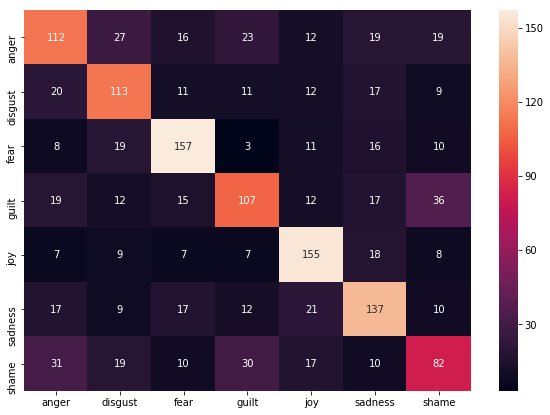

In [300]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

l = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]
l.sort()
df_cm = pd.DataFrame(matrix, index = l, columns = l)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

In [301]:
label_freq = {}
for label, _ in psychExp_txt: 
    label_freq[label] = label_freq.get(label, 0) + 1

# print the labels and their counts in sorted order 
for l in sorted(label_freq, key=label_freq.get, reverse=True):
    print("{:10}({})  {}".format(convert_label(l, emotions), l, label_freq[l]))

joy       (1. 0. 0. 0. 0. 0. 0.)  1084
anger     (0. 0. 1. 0. 0. 0. 0.)  1080
sadness   (0. 0. 0. 1. 0. 0. 0.)  1079
fear      (0. 1. 0. 0. 0. 0. 0.)  1078
disgust   (0. 0. 0. 0. 1. 0. 0.)  1057
guilt     (0. 0. 0. 0. 0. 0. 1.)  1057
shame     (0. 0. 0. 0. 0. 1. 0.)  1045


In [302]:
emoji_dict = {"joy":"😂", "fear":"😱", "anger":"😠", "sadness":"😢", "disgust":"😒", "shame":"😳", "guilt":"😔"}

In [357]:
t1 = predict_captions(try_image)
t2 = beam_search_predictions(try_image, beam_index=3)
t3 = beam_search_predictions(try_image, beam_index=5)
t4 = beam_search_predictions(try_image, beam_index=7)
texts = [t1, t2, t3, t4]
for text in texts: 
    features = create_feature(text, nrange=(1, 4))
    features = vectorizer.transform(features)
    prediction = grid_obj.predict(features)[0]
    print("{} {}".format(text,emoji_dict[prediction]))

A little girl in a blue shirt is jumping over a swing . 😒
A little girl in a pink shirt is sitting on a swing . 😳
A little girl and a little girl playing in a field . 😒
A little girl and a little girl play in a field . 😒
